## Device check

In [1]:
!nvidia-smi

Wed Oct 25 01:04:16 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.60.13    Driver Version: 525.60.13    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:16:00.0 Off |                    0 |
| N/A   30C    P0    38W / 300W |      0MiB / 32768MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Packages

In [2]:
import warnings
warnings.filterwarnings(action="ignore")

In [267]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

import lightning.pytorch as pl
import logging
logging.basicConfig(level="INFO")

import math
from matplotlib import pyplot

import numpy as np

import os

import pandas as pd
from pprint import pprint

import sys
sys.path.append("../src")

from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary

In [46]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [190]:
from einops import pack, unpack, repeat, reduce, rearrange

In [321]:
import config
from dataloader import BEDataset, BEDataModule
import token_learner
from transformer import PositionalEncoder, MultiHeadAttention, FeedFowardLayer, generate_masks, generate_causal_attention_mask

from film_layers import FiLMBlockV2, FiLMEncoder, ResBlockDWConv
from rt1 import RT1Encoder
from utils.data_utils import History
from utils.model_utils import TextEncoder, ImageFeatureExtractor, plot_self_attention


## Load data summary

In [6]:
csv = pd.read_csv(os.path.join(config.DATASET_PATH, "train.csv"))

csv.head()

,sample_ID,in_state,goal_state,action_description,motor_cmd,len_action_desc,len_motor_cmd,version
0,7294,0,10,put the fork to the right of buttermilk,:FORK GREEN POSE-9 :BUTTERMILK GREEN POSE-2 :F...,8,11,v2
1,405,0,8,move the bottle backwards,:BOTTLE RED POSE-2 :BOTTLE #'*backward-transf...,4,8,v1
2,4235,0,10,put the bottle to the left of breakfast-cereal,:BOTTLE RED POSE-7 :BREAKFAST-CEREAL BLUE POSE...,8,11,v2
3,6990,0,10,put the milk in front of bottle,:MILK BLUE POSE-8 :BOTTLE RED POSE-4 :MILK #'...,7,11,v2
4,7096,0,10,put the cup in front of glasses,:CUP GREEN POSE-6 :GLASSES RED POSE-2 :CUP #'...,7,11,v2


In [7]:
# building data object
ds = BEDataset(
    df=csv    
)

len(ds)

4876

In [8]:
# fetching example
rand_idx = np.random.randint(low=0, high=len(ds))
ex = ds[rand_idx]

print("Dataset size: ", len(ds))
print("="*100)
print("ID\t: ", ex["sample_id"])
print(">> InState\t: ", ex["in_state"].shape)
print(">> Desc\t:")
pprint(ex["action_desc"])
print(">> Cmd\t:")
pprint(ex["motor_cmd"])
print("="*100)

Dataset size:  4876
ID	:  9401
>> InState	:  torch.Size([3, 224, 224])
>> Desc	:
{'ids': tensor([  101,  2404,  1996,  5442,  2000,  1996,  2157,  1997, 12256, 17130,
         2378,   102,     0,     0,     0,     0]),
 'length': 8,
 'mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0]),
 'raw': 'put the knife to the right of mondamin',
 'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])}
>> Cmd	:
{'ids': tensor([ 0, 17, 41, 30, 18, 41, 36, 17, 48, 18,  2,  2,  2,  2,  2,  2]),
 'length': 11,
 'mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0]),
 'raw': ':KNIFE GREEN POSE-10 :MONDAMIN GREEN POSE-3 :KNIFE  '
        "#'*rightward-transformation*  :MONDAMIN"}


## Data Module

In [9]:
dm = BEDataModule()
dm.setup()

Total # examples: 4876


INFO:root:Training on 3610 samples.
INFO:root:Validating on 1266 samples.


In [10]:
# print("="*100)
# logging.info("\n>> train data loader")
# print(f"# train batches\t: {len(dm.train_dataloader())}")
# for data in dm.train_dataloader():
#     # pprint(data)
#     sample_id, in_state, ad, cmd = data["sample_id"], data["in_state"], data["action_desc"], data["motor_cmd"]
#     print("In \t\t\t: ", in_state.shape)
#     print("Action desc \t\t: ", ad["ids"].shape)
#     print("Action desc (len) \t: ", ad["length"].shape)
#     print("CMD \t\t\t: ", cmd["ids"].shape)
#     print("CMD(len) \t\t: ", cmd["length"].shape)
#     break

# print("\nIDs & decided tokens")
# for data in dm.train_dataloader():
#     print(data["action_desc"]["ids"][0].tolist())
#     print(dm.train_ds._decode_inputs(data["action_desc"]["ids"][0].tolist()))
#     print()
#     print(data["motor_cmd"]["ids"][0].tolist())
#     print(dm.train_ds._decode_outputs(data["motor_cmd"]["ids"][0].tolist()))

#     break
    
# print("="*100)

## Fetch batch

In [147]:
%%time
sample = next(iter(dm.train_dataloader()))
sample["in_state"].shape

CPU times: user 11.5 ms, sys: 167 ms, total: 179 ms
Wall time: 1.55 s


torch.Size([8, 3, 224, 224])

### Utils

In [150]:
# %%time 

# history = History(imgs=sample["in_state"])

# history.carousel.shape

CPU times: user 96.7 ms, sys: 3.87 ms, total: 101 ms
Wall time: 100 ms


torch.Size([8, 3, 6, 224, 224])

In [189]:
# history.display_history()

## Model Design

<!-- ![RT1 model architecture](../../imgs/rt1+.png) -->
<center>
    <img src="../imgs/rt1+.png" alt="RT1 model architecture" width="300" height="400">

<center>

### Encoder

#### Test Text Encoder

In [12]:
# te = TextEncoder(freeze=True).cuda()
# summary(model=te, col_names=["num_params", "trainable"])

In [13]:
# emb = te(
#     inp_ids=sample["action_desc"]["ids"].cuda(),
#     mask=sample["action_desc"]["mask"].cuda(),
#     tok_type_ids=sample["action_desc"]["token_type_ids"].cuda()
# )

# emb.shape

#### Test Img Feature Extractor

In [14]:
# fe = ImageFeatureExtractor(pretrained=True, arch="resnet34").cuda()

# summary(fe, col_names=["num_params", "trainable"])

In [15]:
# img_ftrs = fe(sample["in_state"].cuda())

# img_ftrs.shape

#### Test FiLM Block

In [16]:
# film_block = FiLMBlockV2().cuda()
# print(film_block)
# summary(model=film_block)

In [17]:
# text_cond_ftrs = film_block(
#     img_features=img_ftrs, 
#     conditioning=emb
# )

# text_cond_ftrs.shape

#### Test Residual FiLM Block

In [18]:
# dw_res = ResBlockDWConv(512, 512).cuda()
# summary(model=dw_res)

In [19]:
# text_cond_ftrs_res = dw_res(
#     img_features=img_ftrs, 
#     conditioning=emb
# )

# text_cond_ftrs_res.shape

#### Test FiLM Encoder

In [20]:
# film_encoder = FiLMEncoder(
#     arch="resnet34",
#     n_res_blocks=6,
# ).cuda()

# # print(film_encoder)
# summary(model=film_encoder)

In [21]:
# %%time

# out = film_encoder(
#     x= sample["in_state"].cuda(),
#     conditioning= emb
# )

# out.shape

#### Token Learner

In [22]:
# N, C, H_W = out.shape
# N, C, H_W

In [23]:
# tokL_v11 = token_learner.TokenLearnerModuleV11(feature_shape=(N, H_W, C)).cuda()
# print(tokL_v11)
# summary(model=tokL_v11)

In [24]:
# learned_tokens = tokL_v11(out.view(N, H_W, C))
# learned_tokens.shape

#### RT-1 Encoder

In [154]:
tokenized_inputs = torch.empty((B, config.NUM_HISTORY+1, config.D_MODEL, config.NUM_LEARNED_TOKENS))
tokenized_inputs.shape

torch.Size([8, 6, 512, 8])

In [155]:
tokenized_inputs.view(B, -1, config.D_MODEL).shape

torch.Size([8, 48, 512])

In [156]:
history.carousel.shape

torch.Size([8, 3, 6, 224, 224])

In [ ]:
history.carousel.[0, :, ]

In [182]:
encoder = RT1Encoder(cnn_bacnbone="resnet34").to(config.DEVICE)
summary(model=encoder, col_names=["num_params", "trainable"])

Layer (type:depth-idx)                                       Param #                   Trainable
RT1Encoder                                                   --                        Partial
├─TextEncoder: 1-1                                           --                        False
│    └─BertModel: 2-1                                        --                        False
│    │    └─BertEmbeddings: 3-1                              (15,891,456)              False
│    │    └─BertEncoder: 3-2                                 (12,609,536)              False
│    │    └─BertPooler: 3-3                                  (262,656)                 False
│    └─Dropout: 2-2                                          --                        --
├─FiLMEncoder: 1-2                                           --                        Partial
│    └─ImageFeatureExtractor: 2-3                            --                        Partial
│    │    └─ResNet: 3-4                                      21

In [183]:
%%time 

src_enc, tokens = encoder._encode(
    input_ids=sample["action_desc"]["ids"].cuda(),
    attn_mask=sample["action_desc"]["mask"].cuda(),
    token_type_ids=sample["action_desc"]["token_type_ids"].cuda(),
    imgs=sample["in_state"].cuda()
)

src_enc.shape, tokens.shape

CPU times: user 17.2 ms, sys: 9.84 ms, total: 27 ms
Wall time: 25.9 ms


(torch.Size([8, 512]), torch.Size([8, 512, 8]))

In [207]:
%%time

src_enc, tokenized_inputs = encoder(
    input_ids=sample["action_desc"]["ids"].cuda(),
    attn_mask=sample["action_desc"]["mask"].cuda(),
    token_type_ids=sample["action_desc"]["token_type_ids"].cuda(),
    imgs=sample["in_state"].cuda()
)

tokenized_inputs.shape, tokenized_inputs.device

CPU times: user 185 ms, sys: 53.8 ms, total: 239 ms
Wall time: 311 ms


torch.Size([8, 48, 512])

### Decoder

In [239]:
pos_encoding = PositionalEncoder().cuda()

In [240]:
pos_enc = pos_encoding(tokenized_inputs)
print(pos_enc.shape)

learned_tokens = tokenized_inputs + pos_enc

torch.Size([8, 48, 512])


In [248]:
attn_mask = generate_causal_attention_mask()
attn_mask.shape

torch.Size([48, 48])

#### Transformer Decoder

#### Cross Attention Layer

In [340]:
class CrossAttention(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout_rate):
        super(CrossAttention, self).__init__()
        
        self.inf = 1e9
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.d_k = self.embed_dim // self.num_heads
        
        # Linear transformations for queries, keys, and values for input and output sequences
        self.w_q_input = nn.Linear(embed_dim, embed_dim, bias=False)
        self.w_k_input = nn.Linear(embed_dim, embed_dim, bias=False)
        self.w_v_input = nn.Linear(embed_dim, embed_dim, bias=False)
        self.w_q_output = nn.Linear(embed_dim, embed_dim, bias=False)
        self.w_k_output = nn.Linear(embed_dim, embed_dim, bias=False)
        self.w_v_output = nn.Linear(embed_dim, embed_dim, bias=False)

        self.dropout = nn.Dropout(dropout_rate)
        self._softmax = nn.Softmax(dim=-1)

    def forward(self, input_seq, output_seq):
        input_shape = input_seq.shape
        output_shape = output_seq.shape

        # Linear transformations + split into num_heads for both input and output sequences
        q_input = self.w_q_input(input_seq).view(input_shape[0], -1, self.num_heads, self.d_k)
        k_input = self.w_k_input(input_seq).view(input_shape[0], -1, self.num_heads, self.d_k)
        v_input = self.w_v_input(input_seq).view(input_shape[0], -1, self.num_heads, self.d_k)
        q_output = self.w_q_output(output_seq).view(output_shape[0], -1, self.num_heads, self.d_k)
        k_output = self.w_k_output(output_seq).view(output_shape[0], -1, self.num_heads, self.d_k)
        v_output = self.w_v_output(output_seq).view(output_shape[0], -1, self.num_heads, self.d_k)

        # Transpose dimensions for input and output sequences
        q_input = q_input.transpose(1, 2)
        k_input = k_input.transpose(1, 2)
        v_input = v_input.transpose(1, 2)
        q_output = q_output.transpose(1, 2)
        k_output = k_output.transpose(1, 2)
        v_output = v_output.transpose(1, 2)

        # Calculate cross-attention scores
        attn_scores = torch.matmul(q_output, k_input.transpose(-2, -1))  # (B, num_heads, L_output, L_input)
        attn_scores = attn_scores / math.sqrt(self.embed_dim)

        # Softmax
        attn_W = self._softmax(attn_scores)
        attn_W = self.dropout(attn_W)

        # Calculate cross-attention values
        attn_values = torch.matmul(attn_W, v_input)  # (B, num_heads, L_output, embed_dim)

        return attn_values, attn_W

In [332]:
input_seq = torch.randn(3, 10, 512) 
output_seq = torch.randn(3, 12, 512)  


In [341]:
num_heads = 4
cross_attention = CrossAttention(embed_dim=512, num_heads=num_heads, dropout_rate=0.1)
cross_attention.eval()

attention_v, attention_w = cross_attention(input_seq, output_seq)
attention_v.shape, attention_w.shape

(torch.Size([3, 4, 12, 128]), torch.Size([3, 4, 12, 10]))

#### Plot Cross attention

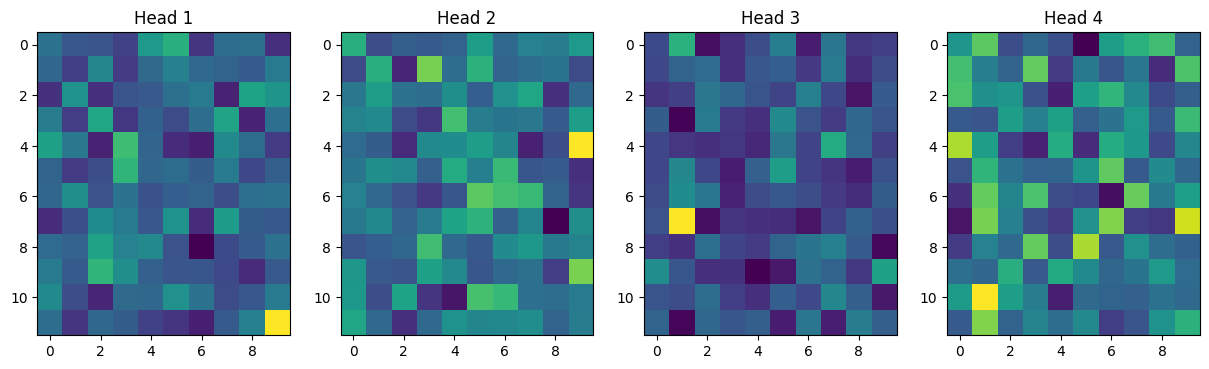

In [342]:
fig, axes = pyplot.subplots(1, num_heads, figsize=(15, 5))
for head_idx in range(num_heads):
    attention_weights_example_head = attention_w[example_idx, head_idx].cpu().detach().numpy()
    ax = axes[head_idx]
    ax.imshow(attention_weights_example_head, cmap='viridis')
    ax.set_title(f'Head {head_idx + 1}')
pyplot.show()

In [278]:
class TransformerDecoderLayer(nn.Module):
    def __init__(
        self, 
        d_model:int=config.D_MODEL, 
        nhead:int=config.N_HEADS, 
        dim_feedforward:int=config.D_FF, 
        dropout:float=config.DECODER_DROPOUT_RATE
    ):
        super().__init__()

        # Multi-head self-attention
        self.self_attn = MultiHeadAttention()
        
        # Layer normalization 1
        self.norm1 = LayerNormalization()
        
        self.multihead_attn = MultiHeadAttention()

        # Layer normalization 2
        self.norm2 = LayerNormalization()
        
        # Position-wise feed-forward network
        self.ff = nn.Sequential(
            nn.Linear(d_model, dim_feedforward),
            nn.GELU(),
            nn.Linear(dim_feedforward, d_model)
        )
        
        # Layer normalization after feed-forward
        self.norm3 = nn.LayerNorm(d_model)
        
        # Dropout
        self.dropout = nn.Dropout(dropout)

    def forward(
        self, 
        inp:torch.Tensor, 
        mask:torch.Tensor=None, 
        return_weights:bool=False
    ):
        
        # Layer normalization 1
        inp = self.norm1(inp)
        
        # Multi-head self-attention
        attn_W = None
        self_attn_output = self.self_attn(inp, inp, inp, mask=mask)
        if return_weights:
            self_attn_output, attn_W = self_attn_output
        
        # Apply dropout and add the residual connection
        inp = inp + self.dropout(self_attn_output)
        
        # Layer normalization 2
        out = self.norm2(inp)
        
        # Apply FF
        ff_out = self.dropout(self.ff(out))
        
        # Add the residual connection
        inp = inp + ff_out

        return inp, attn_W
    

class TransformerDecoder(nn.Module):
    def __init__(
        self, 
        num_layers:int=config.N_DECODER_LAYERS
    ):
        super().__init__()
        
        self.num_layers = num_layers
        # self.target_embedding = nn.Embedding(
        #     num_embeddings=config.TARGET_VOCAB_SIZE, 
        #     embedding_dim=config.D_MODEL, 
        #     padding_idx=config.TARGETS_MAPPING["[PAD]"]
        # )
        
        # token embedding
        self.token_embedding = nn.Linear(in_features=config.NUM_TOKENIZED_INPUTS, out_features=config.D_FF)
               
        # transformer layers
        self.layers = nn.ModuleList([
            TransformerDecoderLayer()
            for _ in range(num_layers)
        ])
        
        self._initialize()
    
    def _initialize(self):
        
        # Glorot / fan_avg. Initialization
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform(p)
            
    def forward(
        self, 
        inp:torch.Tensor, 
        mask:torch.Tensor=None, 
    ):
        
        B, T, D = inp.shape
        
        # positions = torch.eye(T).repeat(B, 1, 1)
        
        # embed tokens
        inp = self.token_embedding(inp)
        # inp = inp + self.position_embedding(positions) # positions to be added 
        
        # run attention self-attention modules
        attn_Ws = []
        for layer in self.layers:
            inp, attn_W = layer(inp, mask=mask)
            if attn_W is not None:
                attn_Ws.append(attn_W)
                
        return inp, attn_Ws

#### Test MultiHeadAttention Layer

In [318]:
mha = MultiHeadAttention().cuda()
print(mha)
summary(mha)

MultiHeadAttention(
  (w_q): Linear(in_features=512, out_features=512, bias=False)
  (w_k): Linear(in_features=512, out_features=512, bias=False)
  (w_v): Linear(in_features=512, out_features=512, bias=False)
  (dropout): Dropout(p=0.1, inplace=False)
  (_softmax): Softmax(dim=-1)
  (output_layer): Linear(in_features=512, out_features=512, bias=True)
)


Layer (type:depth-idx)                   Param #
MultiHeadAttention                       --
├─Linear: 1-1                            262,144
├─Linear: 1-2                            262,144
├─Linear: 1-3                            262,144
├─Dropout: 1-4                           --
├─Softmax: 1-5                           --
├─Linear: 1-6                            262,656
Total params: 1,049,088
Trainable params: 1,049,088
Non-trainable params: 0

In [319]:
mem, attn_w = mha(q=learned_tokens, k=learned_tokens, v=learned_tokens, return_weights=True)

mem.shape, attn_w.shape

q: torch.Size([8, 48, 512]) - k: torch.Size([8, 48, 512]) - v: torch.Size([8, 48, 512]) 


(torch.Size([8, 48, 512]), torch.Size([8, 8, 48, 48]))

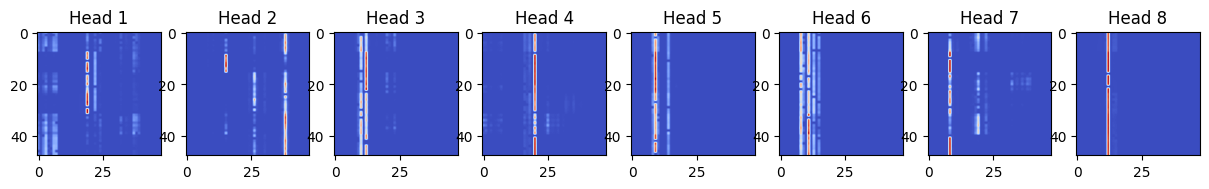

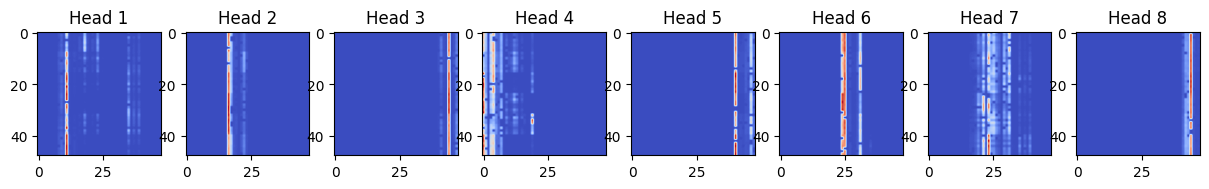

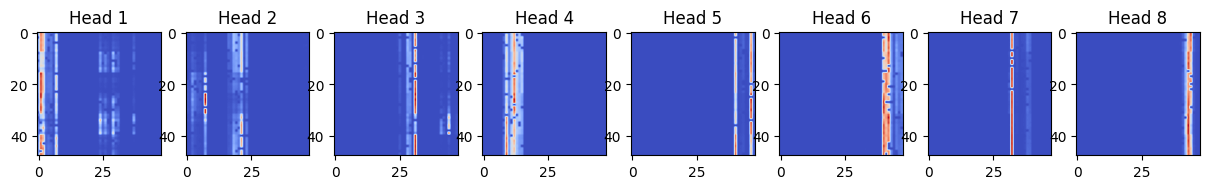

In [320]:
plot_self_attention(attn_w)
plot_self_attention(attn_w, example_idx=2)
plot_self_attention(attn_w, example_idx=4)

#### Test Transformer decoder

In [257]:
dec = TransformerDecoder()
summary(model=dec)

Layer (type:depth-idx)                   Param #
TransformerDecoder                       --
├─Linear: 1-1                            25,088
├─ModuleList: 1-2                        --
│    └─TransformerDecoderLayer: 2-1      --
│    │    └─MultiHeadAttention: 3-1      1,049,088
│    │    └─LayerNormalization: 3-2      1,024
│    │    └─MultiHeadAttention: 3-3      1,049,088
│    │    └─LayerNormalization: 3-4      1,024
│    │    └─Sequential: 3-5              525,312
│    │    └─LayerNorm: 3-6               1,024
│    │    └─Dropout: 3-7                 --
│    └─TransformerDecoderLayer: 2-2      --
│    │    └─MultiHeadAttention: 3-8      1,049,088
│    │    └─LayerNormalization: 3-9      1,024
│    │    └─MultiHeadAttention: 3-10     1,049,088
│    │    └─LayerNormalization: 3-11     1,024
│    │    └─Sequential: 3-12             525,312
│    │    └─LayerNorm: 3-13              1,024
│    │    └─Dropout: 3-14                --
│    └─TransformerDecoderLayer: 2-3      --
│    │    └

In [ ]:
dec_out = dec(
    src=src_enc, 
    encoder_outputs=tokens,
    y=None #sample["motor_cmd"]["ids"].cuda()
)

In [ ]:
src_enc.shape

#### Action Generator

In [251]:
class ActionGenerator(nn.Module):
    def __init__(
        self,
        d_model:int=config.D_MODEL, 
        vocab_size:int=len(config.TARGETS),
        action_bins:int=config.ACTION_BINS,
        num_actons:int=config.NUM_ACTION_SLOTS
    ):
        super().__init__()
        
        # attrs
        self.action_bins = action_bins
        
        # layers
        self.norm = LayerNormalization()
        self.proj = nn.Linear(in_features=d_model, out_features=vocab_size)
        self._softmax = nn.LogSoftmax(dim=-1)

    def forward(self, tokens):
        
        out = self.norm(tokens)
        out = self.proj(out)
        out = self._softmax(out)
        
        return out
    

In [252]:
generator = ActionGenerator().cuda()
print(generator)
summary(generator)

ActionGenerator(
  (norm): LayerNormalization(
    (layer): LayerNorm((512,), eps=1e-06, elementwise_affine=True)
  )
  (proj): Linear(in_features=512, out_features=52, bias=True)
  (_softmax): LogSoftmax(dim=-1)
)


Layer (type:depth-idx)                   Param #
ActionGenerator                          --
├─LayerNormalization: 1-1                --
│    └─LayerNorm: 2-1                    1,024
├─Linear: 1-2                            26,676
├─LogSoftmax: 1-3                        --
Total params: 27,700
Trainable params: 27,700
Non-trainable params: 0

In [ ]:
N, C, T = tokens.shape

N, C, T

In [ ]:
actions = generator(tokens.view(N, T, C))

actions.shape

### RT-1 Decoder

In [ ]:
class RT1Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.positional_encoder = PositionalEncoder()
        self.transformer = TransformerDecoder()
        self.action_generator = ActionGenerator()
        
    def _decode_predictions(self, preds, method:str="greedy"):
        """
            Args:
                preds: predictions (logits)
                method: decoding strategy. one of ["greedy", "beam-search"]
                
            Returns:
                actions: decoded predictions as sequence of actions.
            
        """
        pass
    
    def forward(self, learned_tokens):
        
        # positional encoding
        pos_enc = self.positional_encoder(imgs)
        
        # Generate attention mask
        attention_mask = generate_causal_attention_mask()
        # Add positional encoding
        pos_enc = pos_encoding(learned_tokens)
        # print(pos_enc.shape)
        learned_tokens = learned_tokens + pos_enc
        # Attend to learned tokens
        attended_tokens = self.transformer(learned_tokens, mask = ~attention_mask)
        out = reduce(attended_tokens, 'b (f n) d -> b f d', 'mean', f = (config.NUM_HISTORY + 1))
        
        # generate outputs
        logits = self.action_generator(out)
        
        return logits

### RT-1 

In [ ]:
class RT1(pl.LightningModule):
    def __init__(
        self
    ):
        super().__init__()
        self.encoder = RT1Encder()
        self.decoder = RT1Decoder()
        
    def forward(self, input_ids, attn_mask, token_type_ids, imgs):
        
        tokens = self.encode(input_ids, attn_mask, token_type_ids, imgs)
        out = self.decode(tokens, )
    
    def encode(self, input_ids, attn_mask, token_type_ids, imgs):
        return self.encoder(input_ids, attn_mask, token_type_ids, imgs)
    
    def decode(self, enc_outputs, x_mask, y, y_mask):
        return self.decoder(y, enc_outputs, src_mask, tgt_mask)
    
    def configure_optimizers(self):
        pass
    
    def training_step(self, batch, batch_idx):
        pass
    
    def validation_step(self, batch, batch_idx):
        pass
    
    def test_step(self, batch, batch_idx):
        pass
    
    def compute_loss(self, outputs, targets):
        pass